# Reliance Test
## predict the risk of hospital readmission for patients 

## Let's configure our environment

In [5]:
import sys
!{sys.executable} -m pip install sagemaker==2.42.0 -U
!{sys.executable} -m pip install sagemaker-experiments
!{sys.executable} -m pip install xgboost==1.3.3
#!pip freeze | grep sagemaker
#!pip freeze | grep xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [6]:
import pandas as pd
import boto3
import sagemaker

sess = boto3.Session()
region = sess.region_name
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()

region = sess.region_name
account_id = sess.client('sts', region_name=region).get_caller_identity()["Account"]
bucket = 'sagemaker-studio-{}-{}'.format(sess.region_name, account_id)
prefix = 'xgboost-readmission-predictor'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print("Looks like you already have a bucket of this name. That's good!")

framework_version = '1.2-2'
docker_image_name = sagemaker.image_uris.retrieve(framework='xgboost', region=region, version=framework_version)

# Workaround while versions are not updated in SM SDK
framework_version = '1.3-1'
docker_image_name = docker_image_name[:-5] + framework_version

print("Setting some useful environment variables (bucket, prefix, region, docker_image_name)...")
%store bucket
%store prefix
%store region
%store docker_image_name
%store framework_version

Setting some useful environment variables (bucket, prefix, region, docker_image_name)...
Stored 'bucket' (str)
Stored 'prefix' (str)
Stored 'region' (str)
Stored 'docker_image_name' (str)
Stored 'framework_version' (str)


---
## Let's upload the data to S3

In [24]:
local_raw_path = "readmission.csv"
raw_dir = f"{prefix}/data/raw"
s3uri_raw = sagemaker.s3.S3Uploader.upload(local_raw_path, f's3://{bucket}/{raw_dir}')
s3uri_raw

's3://sagemaker-studio-us-east-1-713782020867/xgboost-readmission-predictor/data/raw/readmission.csv'

Store the raw data S3 URI for later:

In [25]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "Reliance/xgboost-risk-predictor"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
role

'arn:aws:iam::713782020867:role/service-role/AmazonSageMaker-ExecutionRole-20220226T125597'

In [29]:
import io
import os
import sys
import time
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display as dis
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from IPython import display 
import pandas as pd
import seaborn as sns


In [86]:
#loading Dataset
df = pd.read_csv("readmission.csv")

In [87]:
#displaying first 10 rows of data
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
ID.Codes,0005EC02F1DC3A15,0005EC02F1DC3A15,0006C4369B0D7B5F,000960C9E1C43BE4,00098CF15837D918,00098CF15837D918,0009FBE350ADD6AC,0009FBE350ADD6AC,000C9F383AB934B2,000DD450CF549664
Readmission.Status,0,0,0,0,0,0,0,0,0,0
Gender,M,M,M,F,M,M,F,F,M,F
Race,White,White,White,White,White,White,White,White,White,Other
ER,0,0,0,0,0,0,1,1,0,0
DRG.class,MED,SURG,MED,SURG,SURG,SURG,MED,MED,SURG,MED
LOS,3,2,2,12,4,5,3,4,4,4
Age,71,71,68,79,91,91,82,83,43,85
HCC.Riskscore,1.631,1.631,0.585,1.66,1.768,1.768,3.885,0.641,0.376,0.632
DRG.Complication,MedicalMCC.CC,Other,MedicalNoC,SurgNoC,SurgNoC,SurgMCC.CC,MedicalNoC,Other,SurgMCC.CC,MedicalMCC.CC


In [33]:
#checking shape of the dataset
df.shape

(66782, 10)

In [92]:
#Checking data types of each variable
num_vars = df.columns[df.dtypes != 'object']
cat_vars = df.columns[df.dtypes == 'object']

print(num_vars, cat_vars)

Index(['Readmission.Status', 'ER', 'LOS', 'Age', 'HCC.Riskscore'], dtype='object') Index(['ID.Codes', 'Gender', 'Race', 'DRG.class', 'DRG.Complication'], dtype='object')


In [96]:
#Checking for missing values in dataset
df[num_vars].isnull().sum()

Readmission.Status    0
ER                    0
LOS                   0
Age                   0
HCC.Riskscore         0
dtype: int64

Text(0.5, 1.0, 'Distrinution of Readmission')

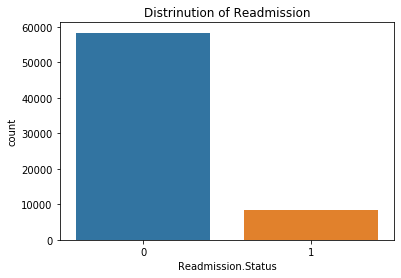

In [42]:
# Distribution of Readmission 
sns.countplot(df['Readmission.Status']).set_title('Distrinution of Readmission')

In [45]:
!pip install imbalanced-learn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


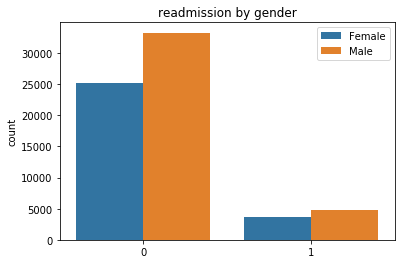

In [50]:
f = sns.countplot(x='Readmission.Status', data=df, hue='Gender')
plt.legend(['Female', 'Male'])
f.set_title("readmission by gender")
f.set_xticklabels(['0', '1'])
plt.xlabel("");

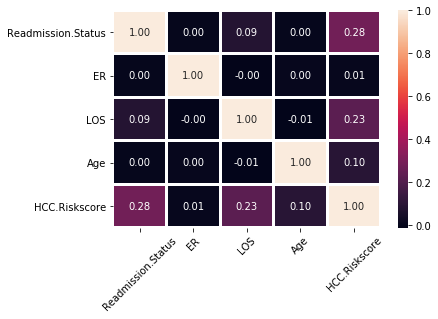

In [51]:
heat_map = sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2f', linewidths=2)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45);

Text(0.5, 1.0, 'Age Distribution of Patients not readmitted')

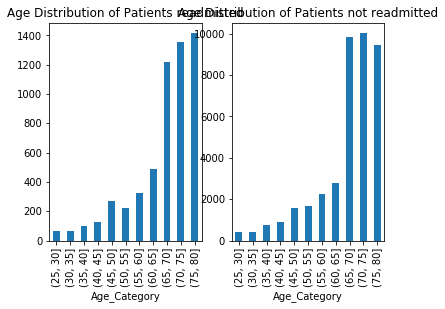

In [64]:
plt.subplot(121)
df[df['Readmission.Status']==1].groupby('Age_Category')['Age'].count().plot(kind='bar')
plt.title('Age Distribution of Patients readmitted')

plt.subplot(122)
df[df['Readmission.Status']==0].groupby('Age_Category')['Age'].count().plot(kind='bar')
plt.title('Age Distribution of Patients not readmitted')

From the above visulaization, we have more elderly generally in the datset.

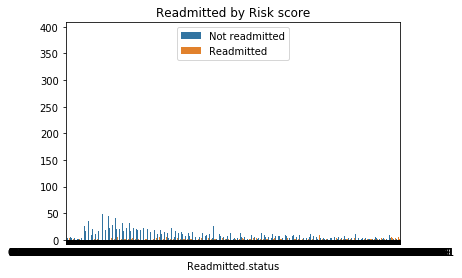

In [69]:
f = sns.countplot(x='HCC.Riskscore', data=df, hue='Readmission.Status')
f.set_title('Readmitted by Risk score')
plt.ylabel('')
plt.xlabel('Readmitted.status')
plt.legend(['Not readmitted', 'Readmitted']);

## Let us One Hot-encode our categorical variables.

In [97]:
categorical_columns = ["Gender", "Race", "DRG.class", "DRG.Complication"]
for column in categorical_columns:
    tempdf = pd.get_dummies(df[column], prefix=column)
    df = pd.merge(
        left=df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df = df.drop(columns=column)
print(df)

               ID.Codes  Readmission.Status  ER  LOS  Age  HCC.Riskscore  \
0      0005EC02F1DC3A15                   0   0    3   71          1.631   
1      0005EC02F1DC3A15                   0   0    2   71          1.631   
2      0006C4369B0D7B5F                   0   0    2   68          0.585   
3      000960C9E1C43BE4                   0   0   12   79          1.660   
4      00098CF15837D918                   0   0    4   91          1.768   
...                 ...                 ...  ..  ...  ...            ...   
66777  FFFC678D34A09F24                   0   0    4   72          3.675   
66778  FFFD086FCB5E0153                   0   0    9   76          1.839   
66779  FFFD086FCB5E0153                   0   0    4   77          1.711   
66780  FFFEC53980B44371                   0   0    9   52          0.655   
66781  FFFEC53980B44371                   0   0    5   53          2.128   

       Gender_F  Gender_M  Race_Black  Race_Hispanic  Race_Other  Race_White  \
0      

## From the Data exploration, there were no missing values and the features were well distributed. But target variable was imbalanced. Let's drop the ID.codes column.

In [101]:
#drop the ID.Codes column.
df.drop(df.columns[[0]], axis=1, inplace=True)
print(df)

       Readmission.Status  ER  LOS  Age  HCC.Riskscore  Gender_F  Gender_M  \
0                       0   0    3   71          1.631         0         1   
1                       0   0    2   71          1.631         0         1   
2                       0   0    2   68          0.585         0         1   
3                       0   0   12   79          1.660         1         0   
4                       0   0    4   91          1.768         0         1   
...                   ...  ..  ...  ...            ...       ...       ...   
66777                   0   0    4   72          3.675         0         1   
66778                   0   0    9   76          1.839         1         0   
66779                   0   0    4   77          1.711         1         0   
66780                   0   0    9   52          0.655         1         0   
66781                   0   0    5   53          2.128         1         0   

       Race_Black  Race_Hispanic  Race_Other  Race_White  DRG.c

## Let's split the dataset

In [103]:
train_data, validation_data, test_data = np.split(
    df.sample(frac=1, random_state=1729),
    [int(0.7 * len(df)), int(0.9 * len(df))],
)
train_data.shape, validation_data.shape, test_data.shape

((46747, 19), (13356, 19), (6679, 19))

In [106]:
train_data.head(2)

,Readmission.Status,ER,LOS,Age,HCC.Riskscore,Gender_F,Gender_M,Race_Black,Race_Hispanic,Race_Other,Race_White,DRG.class_MED,DRG.class_SURG,DRG.class_UNGROUP,DRG.Complication_MedicalMCC.CC,DRG.Complication_MedicalNoC,DRG.Complication_Other,DRG.Complication_SurgMCC.CC,DRG.Complication_SurgNoC
31631,0,2,6,77,2.257,1,0,0,0,0,1,1,0,0,1,0,0,0,0
2600,0,0,9,65,1.359,1,0,0,0,0,1,1,0,0,0,0,1,0,0


In [107]:
validation_data.head(2)

,Readmission.Status,ER,LOS,Age,HCC.Riskscore,Gender_F,Gender_M,Race_Black,Race_Hispanic,Race_Other,Race_White,DRG.class_MED,DRG.class_SURG,DRG.class_UNGROUP,DRG.Complication_MedicalMCC.CC,DRG.Complication_MedicalNoC,DRG.Complication_Other,DRG.Complication_SurgMCC.CC,DRG.Complication_SurgNoC
11344,1,0,4,67,4.291,1,0,0,0,1,0,0,1,0,0,0,0,1,0
31438,0,1,2,68,1.364,1,0,0,0,0,1,1,0,0,0,1,0,0,0


In [108]:
test_data.head(2)

,Readmission.Status,ER,LOS,Age,HCC.Riskscore,Gender_F,Gender_M,Race_Black,Race_Hispanic,Race_Other,Race_White,DRG.class_MED,DRG.class_SURG,DRG.class_UNGROUP,DRG.Complication_MedicalMCC.CC,DRG.Complication_MedicalNoC,DRG.Complication_Other,DRG.Complication_SurgMCC.CC,DRG.Complication_SurgNoC
31631,0,2,6,77,2.257,1,0,0,0,0,1,1,0,0,1,0,0,0,0
2600,0,0,9,65,1.359,1,0,0,0,0,1,1,0,0,0,0,1,0,0


In [110]:
df.shape

(66782, 19)

## Create CSV files for the split datasets

In [111]:
train_file_name = "train.csv"
validation_file_name = "validation.csv"
test_file_name = "test.csv"

train_data.to_csv(train_file_name , header=False, index=False)
validation_data.to_csv(validation_file_name, header=False, index=False)
test_data.to_csv(test_file_name, header=False, index=False)

## Upload files to s3

In [112]:
train_dir = f"{prefix}/data/train"
val_dir = f"{prefix}/data/validation"
test_dir = f"{prefix}/data/test"

s3uri_train = sagemaker.s3.S3Uploader.upload(train_file_name, f's3://{bucket}/{train_dir}')
s3uri_validation = sagemaker.s3.S3Uploader.upload(validation_file_name, f's3://{bucket}/{val_dir}')
s3uri_test = sagemaker.s3.S3Uploader.upload(test_file_name, f's3://{bucket}/{test_dir}')
s3uri_train, s3uri_validation, s3uri_test

('s3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/data/train/train.csv',
 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/data/validation/validation.csv',
 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/data/test/test.csv')

## Let us Model the data

In [113]:
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [114]:
import pprint
from time import strftime, gmtime

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent

---
## Train

We'll use the XGBoost library to train a class of models known as gradient boosted decision trees on the data that we just uploaded. 


In [115]:
from sagemaker.inputs import TrainingInput

In [117]:
s3_input_train = TrainingInput(s3_data=s3uri_train, content_type='csv')
s3_input_validation = TrainingInput(s3_data=s3uri_validation, content_type='csv')

In [118]:
pprint.pprint(s3_input_train.config)

{'ContentType': 'csv',
 'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
                                 'S3DataType': 'S3Prefix',
                                 'S3Uri': 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/data/train/train.csv'}}}


In [119]:
pprint.pprint(s3_input_validation.config)

{'ContentType': 'csv',
 'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
                                 'S3DataType': 'S3Prefix',
                                 'S3Uri': 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/data/validation/validation.csv'}}}


### Amazon SageMaker Experiments allows me to keep track of my model training





In [120]:
# Helper to create timestamps
create_date = lambda: strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [122]:
readmission_predictor_experiment = Experiment.create(experiment_name=f"readmission-predictor-xgboost-{create_date()}", 
                                              description="Using xgboost to predict customer churn", 
                                              sagemaker_boto_client=boto3.client('sagemaker'))

#### Hyperparameters
Now we can specify our XGBoost hyperparameters.

In [123]:
hyperparams = {"max_depth":5,
               "subsample":0.8,
               "num_round":600,
               "eta":0.2,
               "gamma":4,
               "min_child_weight":6,
               "objective":'binary:logistic',
               "verbosity": 0
              }

In [143]:
%%writefile xgboost_readmission_predictor.py
import argparse
import json
import os
import pickle
import random
import tempfile
import urllib.request

import xgboost
from smdebug import SaveConfig
from smdebug.xgboost import Hook


def parse_args():

    parser = argparse.ArgumentParser()

    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--gamma", type=int, default=4)
    parser.add_argument("--min_child_weight", type=int, default=6)
    parser.add_argument("--subsample", type=float, default=0.8)
    parser.add_argument("--verbosity", type=int, default=0)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--num_round", type=int, default=50)
    parser.add_argument("--smdebug_path", type=str, default=None)
    parser.add_argument("--smdebug_frequency", type=int, default=1)
    parser.add_argument("--smdebug_collections", type=str, default='metrics')
    parser.add_argument("--output_uri", type=str, default="/opt/ml/output/tensors",
                        help="S3 URI of the bucket where tensor data will be stored.")

    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    
    args = parser.parse_args()

    return args


def create_smdebug_hook(out_dir, train_data=None, validation_data=None, frequency=1, collections=None,):

    save_config = SaveConfig(save_interval=frequency)
    hook = Hook(
        out_dir=out_dir,
        train_data=train_data,
        validation_data=validation_data,
        save_config=save_config,
        include_collections=collections,
    )

    return hook


def main():
    
    args = parse_args()

    train, validation = args.train, args.validation
    parse_csv = "?format=csv&label_column=0"
    dtrain = xgboost.DMatrix(train+parse_csv)
    dval = xgboost.DMatrix(validation+parse_csv)

    watchlist = [(dtrain, "train"), (dval, "validation")]

    params = {
        "max_depth": args.max_depth,
        "eta": args.eta,
        "gamma": args.gamma,
        "min_child_weight": args.min_child_weight,
        "subsample": args.subsample,
        "verbosity": args.verbosity,
        "objective": args.objective}

    # The output_uri is a the URI for the s3 bucket where the metrics will be
    # saved.
    output_uri = (
        args.smdebug_path
        if args.smdebug_path is not None
        else args.output_uri
    )

    collections = (
        args.smdebug_collections.split(',')
        if args.smdebug_collections is not None
        else None
    )

    hook = create_smdebug_hook(
        out_dir=output_uri,
        frequency=args.smdebug_frequency,
        collections=collections,
        train_data=dtrain,
        validation_data=dval,
    )

    bst = xgboost.train(
        params=params,
        dtrain=dtrain,
        evals=watchlist,
        num_boost_round=args.num_round,
        callbacks=[hook])
    
    if not os.path.exists(args.model_dir):
        os.makedirs(args.model_dir)

    model_location = os.path.join(args.model_dir, 'xgboost-model')
    pickle.dump(bst, open(model_location, 'wb'))


if __name__ == "__main__":

    main()


def model_fn(model_dir):
    """Load a model. For XGBoost Framework, a default function to load a model is not provided.
    Users should provide customized model_fn() in script.
    Args:
        model_dir: a directory where model is saved.
    Returns:
        A XGBoost model.
        XGBoost model format type.
    """
    model_files = (file for file in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, file)))
    model_file = next(model_files)
    try:
        booster = pickle.load(open(os.path.join(model_dir, model_file), 'rb'))
        format = 'pkl_format'
    except Exception as exp_pkl:
        try:
            booster = xgboost.Booster()
            booster.load_model(os.path.join(model_dir, model_file))
            format = 'xgb_format'
        except Exception as exp_xgb:
            raise ModelLoadInferenceError("Unable to load model: {} {}".format(str(exp_pkl), str(exp_xgb)))
    booster.set_param('nthread', 1)
    return booster, format


def predict_fn(input_object, model):
    """
    Perform prediction on the deserialized object, with the loaded model.
    """
    X_test = xgboost.DMatrix(input_object.values)
    predictions_probs = model.predict(X_test)
    predictions = predictions_probs.round()
    return {"predictions": predictions}


def input_fn(request_body, content_type):
    """
    Perform preprocessing task on inference dataset.
    """
    if content_type == "text/csv":
        df = pd.read_csv(StringIO(request_body), header=None)
        return df
    else:
        raise ValueError("{} not supported by script!".format(content_type))

Writing xgboost_readmission_predictor.py


In [144]:
from sagemaker.xgboost.estimator import XGBoost
role = sagemaker.get_execution_role()
sm_sess = sagemaker.session.Session()

In [145]:
train_script_name = 'xgboost_readmission_predictor.py'

trial = Trial.create(trial_name=f'framework-mode-trial-{create_date()}', 
                     experiment_name=readmission_predictor_experiment.experiment_name,
                     sagemaker_boto_client=boto3.client('sagemaker'))

### Setting up Amazon SageMaker Debugger


In [146]:
debug_rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
               Rule.sagemaker(rule_configs.overtraining()),
               Rule.sagemaker(rule_configs.overfit())
              ]

In [150]:
framework_xgb = XGBoost(image_uri=docker_image_name,
                        entry_point=train_script_name,
                        role=role,
                        framework_version=framework_version,
                        py_version="py3",
                        hyperparameters=hyperparams,
                        instance_count=1, 
                        instance_type='ml.m4.xlarge',
                        output_path=f's3://{bucket}/{prefix}/output',
                        base_job_name='readmission-predictor-experiment',
                        sagemaker_session=sm_sess,
                        rules=debug_rules
                        )


framework_xgb.fit(inputs={
                      'train': s3_input_train,
                      'validation': s3_input_validation
                         },
                  experiment_config={
                      'ExperimentName': readmission_predictor_experiment.experiment_name, 
                      'TrialName': trial.trial_name,
                      'TrialComponentDisplayName': 'Training'
                  }
                 )

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: readmission-predictor-experiment-2022-03-01-17-04-49-538


2022-03-01 17:04:49 Starting - Starting the training job...LossNotDecreasing: InProgress
Overtraining: InProgress
Overfit: InProgress
ProfilerReport-1646154289: InProgress
...
2022-03-01 17:05:44 Starting - Launching requested ML instances.........
2022-03-01 17:07:14 Starting - Preparing the instances for training............
2022-03-01 17:09:13 Downloading - Downloading input data...
2022-03-01 17:09:46 Training - Downloading the training image..[2022-03-01 17:10:00.379 ip-10-0-178-37.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-01:17:10:00:INFO] Imported framework sagemaker_xgboost_container.training
[2022-03-01:17:10:00:INFO] No GPUs detected (normal if no gpus installed)
[2022-03-01:17:10:00:INFO] Invoking user training script.

2022-03-01 17:10:13 Training - Training image download completed. Training in progress.[2022-03-01:17:10:16:INFO] Module xgboost_readmission_predictor does not provide a setup.py. 
Generating setup.py
[2022-03-01:17:10:16:I

## Save training Job

In [151]:
training_job_name = framework_xgb.latest_training_job.job_name
training_job_name

'readmission-predictor-experiment-2022-03-01-17-04-49-538'

In [152]:
%store training_job_name

Stored 'training_job_name' (str)


## Store the S3 URI and training script name where our training script was saved

In [153]:
framework_xgb.hyperparameters()

{'max_depth': '5',
 'subsample': '0.8',
 'num_round': '600',
 'eta': '0.2',
 'gamma': '4',
 'min_child_weight': '6',
 'objective': '"binary:logistic"',
 'verbosity': '0',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-713782020867/readmission-predictor-experiment-2022-03-01-17-04-49-538/source/sourcedir.tar.gz"',
 'sagemaker_program': '"xgboost_readmission_predictor.py"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"readmission-predictor-experiment-2022-03-01-17-04-49-538"',
 'sagemaker_region': '"us-east-1"'}

In [154]:
s3_modeling_code_uri = eval(framework_xgb.hyperparameters()["sagemaker_submit_directory"])
s3_modeling_code_uri

's3://sagemaker-us-east-1-713782020867/readmission-predictor-experiment-2022-03-01-17-04-49-538/source/sourcedir.tar.gz'

In [155]:
%store s3_modeling_code_uri

Stored 's3_modeling_code_uri' (str)


In [156]:
%store train_script_name

Stored 'train_script_name' (str)


## Evaluation

In [162]:
from sagemaker.s3 import S3Uploader, S3Downloader

# Get name of training job and other variables
%store -r training_job_name

training_job_name

'readmission-predictor-experiment-2022-03-01-17-04-49-538'

In [163]:
estimator = sagemaker.estimator.Estimator.attach(training_job_name)
s3uri_model = estimator.model_data
print("\ns3uri_model =",s3uri_model)

S3Downloader.download(s3uri_model, ".")


2022-03-01 17:14:35 Starting - Preparing the instances for training
2022-03-01 17:14:35 Downloading - Downloading input data
2022-03-01 17:14:35 Training - Training image download completed. Training in progress.
2022-03-01 17:14:35 Uploading - Uploading generated training model
2022-03-01 17:14:35 Completed - Training job completed

s3uri_model = s3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/output/readmission-predictor-experiment-2022-03-01-17-04-49-538/output/model.tar.gz


In [165]:
import json
import os
import tarfile
import logging
import pickle

import pandas as pd
import xgboost

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


model_path = "model.tar.gz"
with tarfile.open(model_path) as tar:
    tar.extractall(path=".")

print("Loading xgboost model.")
model = pickle.load(open("xgboost-model", "rb"))
model

Loading xgboost model.


In [167]:
print("Loading test input data")
test_path = "test.csv"
df = pd.read_csv(test_path, header=None)
df

Loading test input data


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,2,6,77,2.257,1,0,0,0,0,1,1,0,0,1,0,0,0,0
1,0,0,9,65,1.359,1,0,0,0,0,1,1,0,0,0,0,1,0,0
2,0,0,7,92,7.310,0,1,0,0,0,1,1,0,0,1,0,0,0,0
3,0,0,7,88,2.211,0,1,0,0,0,1,1,0,0,0,0,1,0,0
4,0,0,4,59,1.822,1,0,0,0,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6674,1,1,8,63,5.593,1,0,0,0,0,1,0,1,0,0,0,0,0,1
6675,0,0,3,53,1.461,0,1,0,0,0,1,1,0,0,1,0,0,0,0
6676,0,2,3,49,2.047,0,1,0,0,0,1,0,1,0,0,0,0,0,1
6677,1,0,11,73,1.697,1,0,0,0,0,1,1,0,0,1,0,0,0,0


In [168]:
print("Reading test data. We should get an `DMatrix` object...")
y_test = df.iloc[:, 0].to_numpy()
df.drop(df.columns[0], axis=1, inplace=True)
X_test = xgboost.DMatrix(df.values)
X_test

Reading test data. We should get an `DMatrix` object...


In [169]:
print("Performing predictions against test data.")
predictions_probs = model.predict(X_test)
predictions = predictions_probs.round()

print("Creating classification evaluation report")
acc = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_probs)

print("Accuracy =", acc)
print("AUC =", auc)

Performing predictions against test data.
Creating classification evaluation report
Accuracy = 0.8736337775116035
AUC = 0.7154107424180318


### Creating a classification report

In [170]:
import pprint
# The metrics reported can change based on the model used - check the link for the documentation 
report_dict = {
    "binary_classification_metrics": {
        "accuracy": {
            "value": acc,
            "standard_deviation": "NaN",
        },
        "auc": {"value": auc, "standard_deviation": "NaN"},
    },
}

print("Classification report:")
pprint.pprint(report_dict)

Classification report:
{'binary_classification_metrics': {'accuracy': {'standard_deviation': 'NaN',
                                                'value': 0.8736337775116035},
                                   'auc': {'standard_deviation': 'NaN',
                                           'value': 0.7154107424180318}}}


In [171]:
evaluation_output_path = os.path.join(
    ".", "evaluation.json"
)
print("Saving classification report to {}".format(evaluation_output_path))

with open(evaluation_output_path, "w") as f:
    f.write(json.dumps(report_dict))

Saving classification report to ./evaluation.json


In [172]:
%%writefile evaluate.py
"""Evaluation script for measuring model accuracy."""

import json
import os
import tarfile
import logging
import pickle

import pandas as pd
import xgboost

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

# May need to import additional metrics depending on what you are measuring.
# See https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

def get_dataset(dir_path, dataset_name) -> pd.DataFrame:
    files = [ os.path.join(dir_path, file) for file in os.listdir(dir_path) ]
    if len(files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(files, dataset_name))
    raw_data = [ pd.read_csv(file, header=None) for file in files ]
    df = pd.concat(raw_data)
    return df

if __name__ == "__main__":
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path="..")

    logger.debug("Loading xgboost model.")
    model = pickle.load(open("xgboost-model", "rb"))

    logger.info("Loading test input data")
    test_path = "/opt/ml/processing/test"
    df = get_dataset(test_path, "test_set")

    logger.debug("Reading test data.")
    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)
    X_test = xgboost.DMatrix(df.values)

    logger.info("Performing predictions against test data.")
    predictions_probs = model.predict(X_test)
    predictions = predictions_probs.round()

    logger.info("Creating classification evaluation report")
    acc = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions_probs)

    # The metrics reported can change based on the model used, but it must be a specific name per (https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html)
    report_dict = {
        "binary_classification_metrics": {
            "accuracy": {
                "value": acc,
                "standard_deviation": "NaN",
            },
            "auc": {"value": auc, "standard_deviation": "NaN"},
        },
    }

    logger.info("Classification report:\n{}".format(report_dict))

    evaluation_output_path = os.path.join(
        "/opt/ml/processing/evaluation", "evaluation.json"
    )
    logger.info("Saving classification report to {}".format(evaluation_output_path))

    with open(evaluation_output_path, "w") as f:
        f.write(json.dumps(report_dict))


Writing evaluate.py


## Let us run the above script

In [174]:
from sagemaker.processing import (
    ProcessingInput,
    ProcessingOutput,
    ScriptProcessor,
)

In [175]:
# Processing step for evaluation
processor = ScriptProcessor(
    image_uri=docker_image_name,
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="readmission/eval-script",
    sagemaker_session=sm_sess,
    role=role,
)

In [176]:
entrypoint = "evaluate.py"

In [177]:
from time import strftime, gmtime
# Helper to create timestamps
create_date = lambda: strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [178]:
processor.run(
    code=entrypoint,
    inputs=[
        sagemaker.processing.ProcessingInput(
            source=s3uri_model,
            destination="/opt/ml/processing/model",
        ),
        sagemaker.processing.ProcessingInput(
            source=s3uri_test,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        sagemaker.processing.ProcessingOutput(
            output_name="evaluation", source="/opt/ml/processing/evaluation"
        ),
    ],
    job_name=f"ReadmissionEval-{create_date()}"
)

INFO:sagemaker:Creating processing-job with name ReadmissionEval-2022-03-01-17-34-53



Job Name:  ReadmissionEval-2022-03-01-17-34-53
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/output/readmission-predictor-experiment-2022-03-01-17-04-49-538/output/model.tar.gz', 'LocalPath': '/opt/ml/processing/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/data/test/test.csv', 'LocalPath': '/opt/ml/processing/test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-713782020867/ReadmissionEval-2022-03-01-17-34-53/input/code/evaluate.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3P

In [180]:
for proc_in in processor.latest_job.inputs:
    if proc_in.input_name == "code":
        s3_evaluation_code_uri = proc_in.source 
        
s3_evaluation_code_uri

's3://sagemaker-us-east-1-713782020867/ReadmissionEval-2022-03-01-17-34-53/input/code/evaluate.py'

In [181]:
%store s3_evaluation_code_uri

Stored 's3_evaluation_code_uri' (str)


### Let's check our evaluation report

In [182]:
out_s3_report_uri = processor.latest_job.outputs[0].destination
out_s3_report_uri

's3://sagemaker-us-east-1-713782020867/ReadmissionEval-2022-03-01-17-34-53/output/evaluation'

In [183]:
reports_list = S3Downloader.list(out_s3_report_uri)
reports_list

['s3://sagemaker-us-east-1-713782020867/ReadmissionEval-2022-03-01-17-34-53/output/evaluation/evaluation.json']

In [184]:
report = S3Downloader.read_file(reports_list[0])

print("=====Model Report====")
print(json.dumps(json.loads(report.split('\n')[0]), indent=2))

=====Model Report====
{
  "binary_classification_metrics": {
    "accuracy": {
      "value": 0.8736337775116035,
      "standard_deviation": "NaN"
    },
    "auc": {
      "value": 0.7154107424180318,
      "standard_deviation": "NaN"
    }
  }
}


In [185]:
model_name="xgboost-readmission-1"

model = estimator.create_model(name=model_name)
container_def = model.prepare_container_def()
sm_sess.create_model(model_name,
                     role,
                     container_def)

INFO:sagemaker:Creating model with name: xgboost-readmission-1


'xgboost-readmission-1'

In [186]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.xlarge',
                                                      sagemaker_session=sm_sess)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [187]:
columns_headers = ['Readmission.Status', 'ER', 'LOS', 'Age', 'HCC.Riskscore	',
       'Gender_F', 'Gender_M', 'Race_Black', 'Race_Hispanic', 'Race_Other',
       'Race_White', 'DRG.class_MED', 'DRG.class_SURG', 'DRG.class_UNGROUP', 'DRG.Complication_MedicalMCC.CC',
       'DRG.Complication_MedicalNoC', 'DRG.Complication_Other', 'DRG.Complication_SurgMCC.CC', 'DRG.Complication_SurgNoC']

### Writing ModelConfig and Bias config

In [195]:
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.m5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv',
                                   content_type='text/csv')



## Explaining Predictions using SHAP

In [189]:
df.columns = columns_headers[1:]
df

,ER,LOS,Age,HCC.Riskscore\t,Gender_F,Gender_M,Race_Black,Race_Hispanic,Race_Other,Race_White,DRG.class_MED,DRG.class_SURG,DRG.class_UNGROUP,DRG.Complication_MedicalMCC.CC,DRG.Complication_MedicalNoC,DRG.Complication_Other,DRG.Complication_SurgMCC.CC,DRG.Complication_SurgNoC
0,2,6,77,2.257,1,0,0,0,0,1,1,0,0,1,0,0,0,0
1,0,9,65,1.359,1,0,0,0,0,1,1,0,0,0,0,1,0,0
2,0,7,92,7.310,0,1,0,0,0,1,1,0,0,1,0,0,0,0
3,0,7,88,2.211,0,1,0,0,0,1,1,0,0,0,0,1,0,0
4,0,4,59,1.822,1,0,0,0,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6674,1,8,63,5.593,1,0,0,0,0,1,0,1,0,0,0,0,0,1
6675,0,3,53,1.461,0,1,0,0,0,1,1,0,0,1,0,0,0,0
6676,2,3,49,2.047,0,1,0,0,0,1,0,1,0,0,0,0,0,1
6677,0,11,73,1.697,1,0,0,0,0,1,1,0,0,1,0,0,0,0


In [190]:
shap_config = clarify.SHAPConfig(baseline=[df.iloc[0].values.tolist()],
                                 num_samples=20,
                                 agg_method='mean_abs',
                                 save_local_shap_values=False)

explainability_output_path = 's3://{}/{}/clarify-explainability'.format(bucket, prefix)

explainability_data_config = clarify.DataConfig(s3_data_input_path=s3uri_train,
                                s3_output_path=explainability_output_path,
                                label='Readmission.Status',
                                headers=columns_headers,
                                dataset_type='text/csv')

shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)



In [191]:
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)

INFO:sagemaker:Creating processing-job with name Clarify-Explainability-2022-03-01-17-53-32-465



Job Name:  Clarify-Explainability-2022-03-01-17-53-32-465
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/data/train/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-713782020867/Reliance/xgboost-risk-predictor/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3Uploa

## Feature Explainability

The Model has `18` input features. We computed KernelShap on the dataset         `dataset` and display the `10` features with the greatest feature attribution.
<br>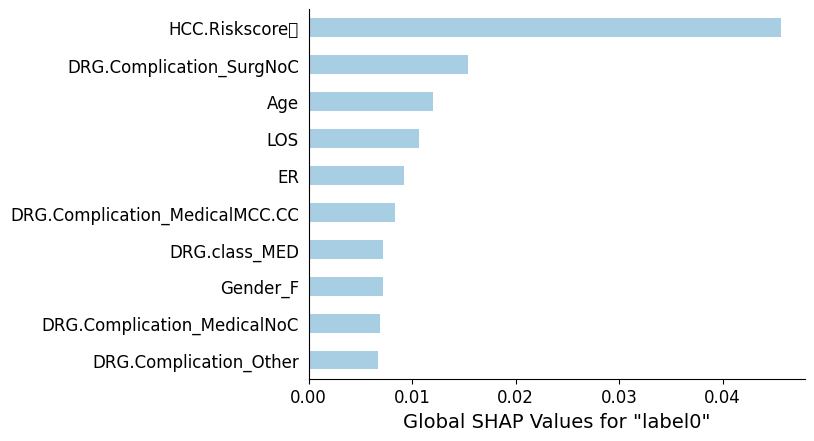<br>